<a href="https://colab.research.google.com/github/CptK1ng/dmc2019/blob/alexander_dev/notebooks/alexander_classificator_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificator v1 by Alexander


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, linear_model, metrics
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

Download our custom Dataset splits:

In [2]:
!wget -nc -q --show-progress https://www.dropbox.com/s/6m8iq9ogpzmu7vx/train_new.csv?dl=1 -O train_new.csv
!wget -nc -q --show-progress https://www.dropbox.com/s/tjpkc45oqn3uv8s/val_new.csv?dl=1 -O val_new.csv

train_new.csv       100%[===================>] 104.09K  --.-KB/s    in 0.03s   
val_new.csv         100%[===================>]  25.96K  --.-KB/s    in 0.007s  


Import Data:

In [3]:
df_train_original = pd.read_csv("train_new.csv", sep="|")
df_val_original = pd.read_csv("val_new.csv", sep="|")
df_train_original.head(2)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,4,828,66.56,7,4,3,0.007246,0.080386,1.166667,0
1,1,1612,31.34,2,4,3,0.008685,0.019442,0.142857,0


## Feature Engineering

In [4]:
def prepareData(df):
  
  df = df.copy()
  df['trustLevel'] = df['trustLevel']/6 #normalization
  """ this custom feature engineering does not improve the score...
  df['totalLineItems'] = df['scannedLineItemsPerSecond'] * df['totalScanTimeInSeconds'] #nur of scanned products
  # df['totalValue'] = df['valuePerSecond'] * df['totalScanTimeInSeconds'] #this is equal to the column "grandTotal"
  # TODO df['lineItemVoids'] = df['lineItemVoidsPerPosition'] * df['totalLineItemVoidsPositions']
  df['lineItemVoidPercentage'] = df['lineItemVoids'] / (df['totalLineItems'] + df['scansWithoutRegistration'])
  df['totalPositions'] = df['totalLineItems'] - df['lineItemVoids'] # + df['quantityModifications']
  """
  return df

df_train = prepareData(df_train_original)
df_val = prepareData(df_val_original)

#df_train = df_train_original.copy()
#df_val = df_val_original.copy()

df_train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,0.666667,828,66.56,7,4,3,0.007246,0.080386,1.166667,0
1,0.166667,1612,31.34,2,4,3,0.008685,0.019442,0.142857,0
2,0.500000,848,52.37,2,4,0,0.022406,0.061757,0.105263,0
3,0.166667,321,76.03,8,7,2,0.071651,0.236854,0.347826,0
4,0.166667,660,6.06,3,7,1,0.027273,0.009182,0.166667,0


## Split X and Y

In [0]:
# Splitting the final dataset into internal training and testing datasets
df_train_X = df_train.drop('fraud', axis=1)
df_train_y = df_train['fraud']
df_val_X = df_val.drop('fraud', axis=1)
df_val_y = df_val['fraud']
X_train, X_test, y_train, y_test = df_train_X.values, df_val_X.values, df_train_y.values, df_val_y.values

## Simple Classificator


In [11]:
def score_function(y_test, y_pred):
  # return metrics.accuracy_score(y_test, y_pred)
  return (0 if all(y_pred == 0) else metrics.fbeta_score(y_test, y_pred, beta=2), np.sum(metrics.confusion_matrix(y_test, y_pred)*np.array([[0, -5],[ -25, 5]])), metrics.confusion_matrix(y_test, y_pred).tolist())
  # return metrics.f1_score(y_test, y_pred)

def get_accuracy(classifier):
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  return score_function(y_test, y_pred)

# Fitting the model and printing the accuracy score
#TODO: 
classifier_sgd = linear_model.SGDClassifier(loss='log', max_iter=4000, tol=1e-3, random_state=0) # Random state is fixed for reproducibility
print("SGD", get_accuracy(classifier_sgd))

SGD (0.15384615384615385, -625, [[319, 34], [19, 4]])


In [12]:
# Printing the confusion matrix
metrics.confusion_matrix(y_test, classifier_sgd.fit(X_train, y_train).predict(X_test))

array([[319,  34],
       [ 19,   4]])

## Other Classificators

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["KNN (K=3)", "Linear SVM", "RBF SVM", "Gaus. Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "Quadr.Dis.A."]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    print(name, "\t\t", get_accuracy(clf))
    

KNN (K=3) 		 (0.0, -610, [[346, 7], [23, 0]])
Linear SVM 		 (0, -575, [[353, 0], [23, 0]])
RBF SVM 		 (0, -575, [[353, 0], [23, 0]])
Gaus. Process 		 (0, -575, [[353, 0], [23, 0]])
Decision Tree 		 (0.4090909090909091, -350, [[344, 9], [14, 9]])
Random Forest 		 (0, -575, [[353, 0], [23, 0]])
Neural Net 		 (0, -575, [[353, 0], [23, 0]])
AdaBoost 		 (0.6578947368421053, -160, [[346, 7], [8, 15]])
Naive Bayes 		 (0.5833333333333333, -280, [[286, 67], [2, 21]])
Quadr.Dis.A. 		 (0.7142857142857142, -115, [[319, 34], [2, 21]])


##  Boosting Methods

GradBoost 	 (0.6756756756756757, -145, [[349, 4], [8, 15]])
AdaBoost 	 (0.782608695652174, -60, [[348, 5], [5, 18]])
XGBoost 	 (0.7522123893805309, -85, [[349, 4], [6, 17]])


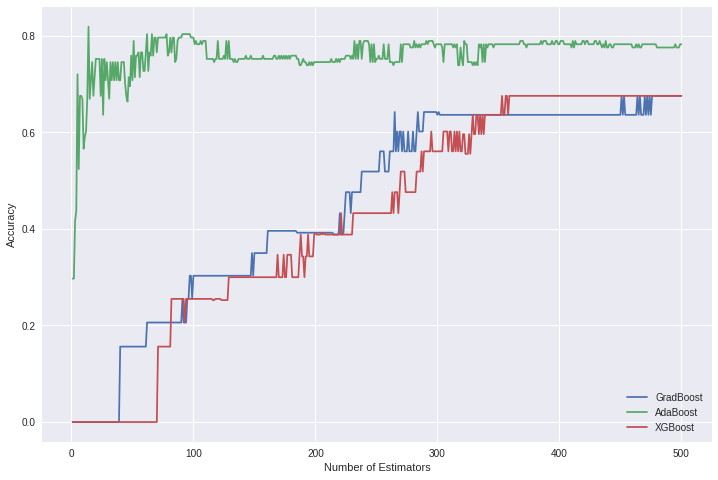

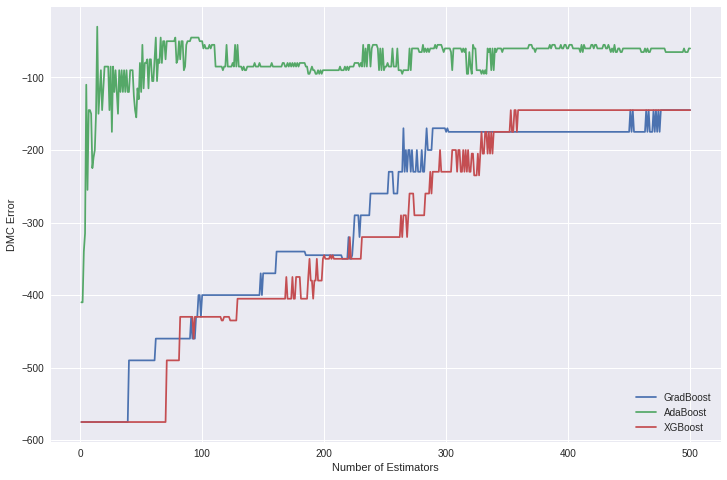

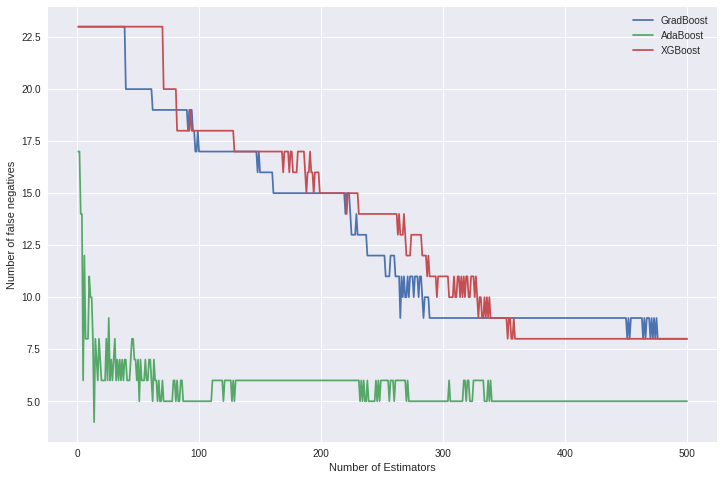

In [40]:
n_estimators=500

# plot the accuracy after each boosting iteration
def get_accuracy_for_n_estimators(classifier):
  accuracy = []
  if (isinstance(classifier, XGBClassifier)):
      for i in range(n_estimators):
          classifier = XGBClassifier(n_estimators=i, random_state=1, max_depth=1)
          classifier.fit(X_train, y_train)
          accuracy.append(score_function(y_test, classifier.predict(X_test)))
  else:
      for i, y_pred in enumerate(classifier.staged_predict(X_test)):
          accuracy.append(score_function(y_test, y_pred))
  return accuracy

 
# GradBoost
classifier_gdb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=1, max_depth=1)
print("GradBoost", "\t", get_accuracy(classifier_gdb) )
accuracy_gdb = get_accuracy_for_n_estimators(classifier_gdb)

# AdaBoost
classifier_adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators, algorithm='SAMME', random_state=1)
print("AdaBoost", "\t", get_accuracy(classifier_adb) )
accuracy_adb = get_accuracy_for_n_estimators(classifier_adb)

# XGBoost
classifier_xgb = XGBClassifier(e_estimators=n_estimators, random_state=1, max_depth=3)
print("XGBoost", "\t", get_accuracy(classifier_xgb) )
accuracy_xgb = get_accuracy_for_n_estimators(classifier_xgb)

# Plot for each number of estimators
plt.figure(figsize=(12, 8))    
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_gdb))[0], label="GradBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_adb))[0], label="AdaBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_xgb))[0], label="XGBoost")
plt.legend()
plt.show()

# Plot for each number of estimators
plt.figure(figsize=(12, 8))    
plt.xlabel('Number of Estimators')
plt.ylabel('DMC Error')
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_gdb))[1], label="GradBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_adb))[1], label="AdaBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*accuracy_xgb))[1], label="XGBoost")
plt.legend()
plt.show()

# Plot for each number of estimators
plt.figure(figsize=(12, 8))    
plt.xlabel('Number of Estimators')
plt.ylabel('Number of false negatives')
plt.plot(np.arange(n_estimators) + 1, list(zip(*list(zip(*list(zip(*accuracy_gdb))[2]))[1]))[0], label="GradBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*list(zip(*list(zip(*accuracy_adb))[2]))[1]))[0], label="AdaBoost")
plt.plot(np.arange(n_estimators) + 1, list(zip(*list(zip(*list(zip(*accuracy_xgb))[2]))[1]))[0], label="XGBoost")
plt.legend()
plt.show()

In [41]:
best_n_estimators = np.argmax(list(zip(*accuracy_adb))[0])+1 # get index of best accuracy

# AdaBoost
classifier_adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=best_n_estimators, algorithm='SAMME', random_state=1)
print("AdaBoost", "\t", get_accuracy(classifier_adb) )

AdaBoost 	 (0.8189655172413792, -30, [[348, 5], [4, 19]])


## Pipelined Classificators

### PCA

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB


classifier_pca = make_pipeline(StandardScaler(), PCA(n_components=5), GaussianNB())
print("PCA", "\t", get_accuracy(classifier_pca) )

PCA 	 (0, -575, [[353, 0], [23, 0]])


## Neural Networks

In [17]:
classifier_mlp = MLPClassifier()
print("MLP", "\t", get_accuracy(classifier_mlp) )

MLP 	 (0, -575, [[353, 0], [23, 0]])


## One more try

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


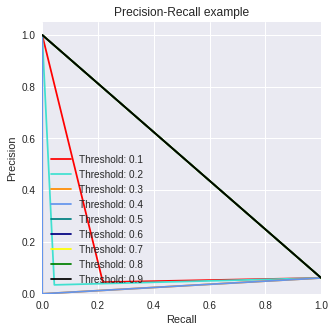

In [18]:
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train,y_train.ravel())
y_pred_proba = lr.predict_proba(X_test)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['red', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'navy', 'yellow', 'green', 'black','yellow'])

plt.figure(figsize=(5,5))

j = 1
for i,color in zip(thresholds,colors):
    y_test_pred_prob = y_pred_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test,y_test_pred_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")


In [0]:
#taken from https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion/35899 (previously from https://www.kaggle.com/malyutins/keras-f2-score)
from keras import backend as K
def fbeta_bce_loss(y_true, y_pred, beta = 2):
  beta_sq = beta ** 2
  tp_loss = K.sum(y_true * (1 - K.binary_crossentropy(y_pred, y_true)), axis=-1)
  fp_loss = K.sum((1 - y_true) * K.binary_crossentropy(y_pred, y_true), axis=-1)

  return - K.mean((1 + beta_sq) * tp_loss / ((beta_sq * K.sum(y_true, axis = -1)) + tp_loss + fp_loss))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                640       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.


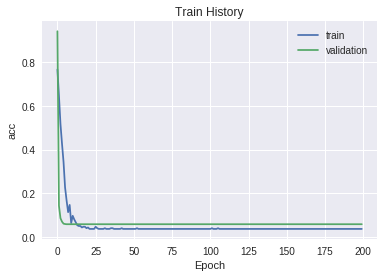

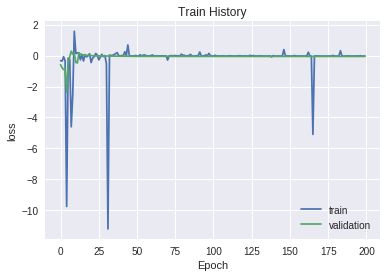

train accuracy = 0.053892215469719486 	train loss = -0.052477965296226906
test  accuracy = 0.06117021308300343 	test  loss = 0.0039648210748713065


NameError: ignored

In [23]:
#from https://www.kaggle.com/randyrose2017/using-scikit-learn-and-keras-for-fraud-detection

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

import matplotlib.pyplot as plt 

def show_train_history(train_history,train,validation):
  plt.plot(train_history.history[train])
  plt.plot(train_history.history[validation])
  plt.title('Train History')
  plt.ylabel(train)
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='best')
  plt.show()

model = Sequential()
model.add(Dense(units=64, input_dim=len(X_train[0]), kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

print(model.summary())

model.compile(loss=fbeta_bce_loss, optimizer='adam', metrics=['accuracy']) # old loss: 'binary_crossentropy'

train_history = model.fit(x=X_train, y=y_train, validation_split=0.8, epochs=200, batch_size=500, verbose=0)


show_train_history(train_history,'acc','val_acc')
show_train_history(train_history,'loss','val_loss')

scores_train = model.evaluate(X_train, y_train, verbose=0)
scores_test = model.evaluate(X_test, y_test, verbose=0)

print('train accuracy =',scores_train[1], '\ttrain loss =',scores_train[0])
print('test  accuracy =',scores_test[1],'\ttest  loss =',scores_test[0])
print("MLP Keras", "\t", score_function(y_test, y_pred))

y_pred = model.predict_classes(X_test)


#model.save_weights("Keras_DMC_Fraud_MLP.h5")
#print('model saved to disk')